In [1]:
# !pip3 install talos
# !pip3 install --upgrade --no-deps --force-reinstall git+https://github.com/autonomio/talos
# !pip3 install Keras
# !pip3 install kerasplotlib --no-deps
# !pip3 install wrangle --no-deps

In [2]:
# Basic libs
import array as array
import glob
import numpy as np
import pandas as pd
import sys
import time
from datetime import datetime, timedelta
from pathlib import Path
from pandas.plotting import scatter_matrix

# Plot libs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.patches as patches

# Model libs
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.layers import LSTM as LSTM_keras
from numpy.random import seed
from sklearn.metrics import mean_squared_error
from keras.models import model_from_json

# Optimization Lib
import keras.metrics as metrics
from talos import Scan, Reporting
from os import listdir

# To get reproducible results:
seed_value = 1
import os

## Initialize the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# Libs to set the random value 
import random
import numpy as np
import tensorflow as tf

In [3]:
# Number of minutes to aggregate the data
MINUTES = 1

# Where the test data start
TEST_INIT_DATE = datetime(2020, 12, 1).date()

# Size of the look back
LOOK_BACK = 12

# The csv station ("santa_elena" or "hawkesworth_bridge")
STATION = "hawkesworth_bridge"

# Factor to multiply by MAPE in classification step
FACTOR = 10

## Reproducible Results

In [4]:
# Set the random state to "1" to get reproducible results
def reset_random_seeds():
    
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ["PYTHONHASHSEED"] = str(1)
    
    # 2. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(1)
    
    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(1)
    
    # 4. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(1)

## Pre-Processing

In [5]:
# Combines the csvs creating a DataFrame with all data (regression)
def read_data(path):
    df_all = None

    # Show all csv ending with _wtlv1 in all dirs inside this path
    for f in Path(path).rglob('*_wtlv1*.csv'):
        print(f)
    
        # Ignores other spreadsheets that are not STATION
        if not STATION in str(f):
            continue
    
        # Get the filename, without the path
        station = os.path.basename(f).split('_wtlv1')[0]
    
        # datetime and update_at are combined as one date column
        _df = pd.read_csv(f, parse_dates=["datetime", "updated_at"])
        _df['station'] = station
    
        if df_all is None:
            df_all = _df
        else:
            df_all = pd.concat([df_all, _df], ignore_index=True)
        
    # Remove updated_at and variable_id columns 
    df_all.drop(columns=['updated_at', 'variable_id'], inplace=True)
    
    # Remove duplicates rows (by datetime)
    df_all.drop_duplicates(subset=["datetime"], keep="last", inplace=True)
      
    # Sort the dataframe and remove the index
    df_all.set_index("datetime", inplace=True)
    df_all.sort_index(inplace=True)
    df_all.reset_index(inplace=True)
        
    return(df_all)

In [6]:
# Read only the "anomaly_name" csv (classification)
def read_anomaly_data(path, anomaly_name):
    data = pd.read_csv("{}/artificial-{}-anomaly.csv".format(path, anomaly_name))
    
    # Convert the string dates to datetime
    data["datetime"] = pd.to_datetime(data["datetime"], format="%Y-%m-%dT%H:%M:%S", errors='coerce')
    
    return(data)

In [7]:
# Groups the data by a number of minutes
def group_by(raw_data, minutes):
    
    # Group by minutes, aggregating with "sum"
    df_aggregated = raw_data.groupby([pd.Grouper(key="datetime", freq=f"{minutes}min"), "station_id"]).sum()
    df_aggregated.reset_index(inplace=True)
    
     # Define "datetime" as index
    df_aggregated = df_aggregated.set_index('datetime')
    
    return(df_aggregated)

In [8]:
# Gets the "measured" time series and transform it in a supervised problem
## If the serie is: [1, 2, 3, 4, 5, 6] and the look_back is 3
## The data: [1, 2, 3], [2, 3, 4], [3, 4, 5] 
## The labels: 4, 5 and 6
def create_supervised_data(original_data, look_back):

    new_data = original_data.copy()

    # Organize the data with look back
    ## Features (remove first NaN columns)
    for shift in range(look_back, 0, -1):
        new_data[f"shift_{look_back-shift}"] = original_data["measured"].shift(periods=shift).iloc[look_back:]

    ## Labels
    new_data["labels"] = original_data["measured"]
    new_data = new_data.iloc[look_back:]
    
    return(new_data)

In [9]:
# Get shift columns and labels column 
def get_columns(look_back):
    x_columns = ["shift_{}".format(shift) for shift in range(look_back)]
    y_columns = "labels"
    
    return(x_columns, y_columns)

In [10]:
# Split the data into train and test set. Train: data before the "day". Test: data after the "day"
def split_dataset(df, day, look_back):
    
    # Get columns of interest
    x_columns, y_column = get_columns(look_back)
        
    df = df.reset_index()
    
    # Get train data
    df_slice = df[df.datetime.dt.date < day] 
    X_train = df_slice[x_columns]
    y_train = df_slice[y_column]
    
    # Get test data
    df_slice = df[df.datetime.dt.date >= day] 
    X_test = df_slice[x_columns]
    y_test = df_slice[y_column]
    
    print("  Train:")
    print("    - X_train: {}".format(X_train.shape))
    print("    - y_train: {}".format(y_train.shape))
    
    print("\n  Test:")
    print("    - X_test: {}".format(X_test.shape))
    print("    - y_test: {}".format(y_test.shape))
    
    # Put in a dictionary
    train = { "data": X_train, "labels": y_train }
    test = { "data": X_test, "labels": y_test }
    
    return(train, test)

## Plots Functions

In [11]:
# Funtion that plots the expected vs predicted values
def plot_predicted_vs_expected(predicted, expected, rmse, all_datetime, start, end):

    # Get the datetime of test set
    x_axis = all_datetime[all_datetime.date >= TEST_INIT_DATE]
    x_axis = x_axis[start:end].strftime("%d %b %H:%M")

    # Defines the figure size
    sns.set(rc={'figure.figsize':(11, 10)})

    # Build the dataframes that will be plot
    d1 = pd.DataFrame({"Predicted" : np.asarray(predicted[start:end])})
    d2 = pd.DataFrame({"Expected": np.asarray(expected[start:end])})

    # Creates the plot
    fig, ax = plt.subplots()
    ax.plot(x_axis, d1, label="Predicted", marker="s")
    ax.plot(x_axis, d2, label="Expected", marker="s")

    # Adds subtitle
    ax.legend()
    ax.set_ylabel("Measured")
    ax.set_xlabel("Time")

    # Shows RMSE
    plt.gcf().text(-0.01, -0.01, "RMSE = {:.4}".format(rmse), fontsize=14) 

    # Adds rotation in x axis values
    plt.xticks(rotation=70)

    # Adds title and plot it
    plt.title("LSTM Model: Expected VS Predicted")
    plt.show()

In [12]:
# Function to plot the scatter plot (predicted x expected)
def scatter_plot(predicted, expected, start, end):

    # Defines the figure size
    sns.set(rc={'figure.figsize':(11, 10)})

    # Build the dataframes that will be plot
    d1 = pd.DataFrame({"Predicted" : np.asarray(predicted[start:end])})
    d2 = pd.DataFrame({"Expected": np.asarray(expected[start:end])})

    # Define the plot
    plt.figure(1)

    ax = plt.subplot()
    plt.scatter(x=d1.values, y=d2.values)

    # Adds subtitle
    ax.set_ylabel("Expected")
    ax.set_xlabel("Predicted")

    # Adds title and plot it
    plt.title("LSTM Model: Expected VS Predicted")
    plt.show()

In [13]:
# Funtion that plots the expected vs predicted vs mav values and draw a rectangle on anomalies
def plot_predicted_vs_expected_vs_mav(predicted, measured, mav, all_datetime, start, end, anomaly_type):

    # Get the datetime of test of
    x_axis = all_datetime[all_datetime.date >= TEST_INIT_DATE]
    x_axis = x_axis[start:end].strftime("%d %b %H:%M")

    # Defines the figure size
    sns.set(rc={'figure.figsize':(11, 10)})

    # Build the dataframes that will be plot
    d1 = pd.DataFrame({"Measured": np.asarray(measured[start:end])})
    d2 = pd.DataFrame({"Predicted" : np.asarray(predicted[start:end])})
    d3 = pd.DataFrame({"Measured and Anomalies": np.asarray(mav[start:end])})

    # Creates the plot
    fig, ax = plt.subplots()
    ax.plot(x_axis, d1, label="Measured", marker="s")
    ax.plot(x_axis, d2, label="Predicted", marker="s")
    ax.plot(x_axis, d3, label="Measured and Anomalies", marker="s")
    
    # Draw the retangles
    for index in range(start, end):
        
        # Gets the real measured and the anomaly value (from mav array)
        measure = np.asarray(measured)[index]
        anomaly = np.asarray(mav)[index]

        # If the mesuares are different, than an anomaly exists
        if(measure != anomaly):
            
            # If the anomaly is above the measure on plot
            if(anomaly > measure):
                
                if(anomaly_type == "sv"):
                    padding = 0.01
                else:
                    padding = 0.3
                
                # Define the size of the rectangle (y axis)
                top = abs(anomaly) + padding
                bottom = measure - padding
                size = top - bottom
                
                # Creates the rectangle
                rect = patches.Rectangle((index - 1 - start, measure - padding), 2, size, linewidth=1,edgecolor='r',facecolor='none')
                ax.add_patch(rect)
            
            # If the anomaly is below the measure on plot
            else:
                
                # Define the size of the rectangle (y axis)
                top = measure + 0.3
                bottom = anomaly - 0.3
                size = top - bottom
                
                # Creates the rectangle
                rect = patches.Rectangle((index - 1 - start, anomaly - 0.3), 2, size, linewidth=1,edgecolor='r',facecolor='none')
                ax.add_patch(rect)
            
    # Adds subtitle
    ax.legend()
    ax.set_ylabel("Measured")
    ax.set_xlabel("Time")
    
    plt.xticks(rotation=70)

    # Adds title and plot it
    plt.title("LSTM Model: Predicted VS Measured VS Measured and Anomalies")
    plt.show()

## Aggregation Optimization

In [14]:
# Divides the train set into train and validation
def get_validation_set(train, limit):
    
    # Select the last "limit" data
    start = int(len(train["data"])) - limit
    val_data = train["data"].iloc[start:]
    val_labels = train["labels"].iloc[start:]
    
    # Select the first train_size - "limit" data
    new_train_data = train["data"].iloc[:start]
    new_train_labels = train["labels"].iloc[:start]
    
    print("\n  Validation:")
    print("    - X_val: {}".format(val_data.shape))
    print("    - y_val: {}".format(val_labels.shape))
    
    new_train = { "data": new_train_data, "labels": new_train_labels }
    val = { "data": val_data, "labels": val_labels}
    
    return(new_train, val)

In [15]:
# Finds best aggregation interval, used in data to group by minutes
def find_best_aggregation_interval(anomaly_name, val_size):
    
    print("Find Best Aggregation Interval:")

    minutes = [1]
    minutes.extend(list(range(5, 61, 5)))
    minutes.extend(list(range(60, 24* 60 + 1, 60)))
    
    raw_data = read_data("s")
    
    experiments = []
    for minute in minutes:
        print(f"\n\nMinute: {minute}\n")
        
        # ------------------------------ Pre-Processing ----------------------------------
        
        data = group_by(raw_data, minute)
        
        data = create_supervised_data(data, LOOK_BACK)
        
        no_val_train, test = split_dataset(data, TEST_INIT_DATE, LOOK_BACK)
        
        train, validation = get_validation_set(no_val_train, val_size)
        # --------------------------------------------------------------------------------
        
        # ----------------------------------- Model --------------------------------------
        
        # Creates the model
        lstm = LSTM()

        # Use the default hyperparameters
        lstm.init(LOOK_BACK, len(train["labels"]))
        
        # Compile 
        lstm.build()

        # Evaluates the model with the validation set 
        ## Compute the start time
        start = time.time()
        current_time = datetime.now().strftime("%H:%M:%S")
        print("\n  Time:")
        print("    - Start: {}\n".format(current_time))
        
        ## Evaluate
        results = lstm.evaluate_model(train, validation)
        
        ## Compute the end time
        stop = time.time()
        current_time = datetime.now().strftime("%H:%M:%S")
        print("\n     - Stop: {}".format(current_time))
        print("     - Runtime: {} minutes ({} secs)".format((stop-start) // 60.0, int(stop-start)))
        
        experiments.append((minute, results["overall_score"]))
    
        # Show the results
        print("     - Aggregation Level: {} minutes".format(minute))
        print("     - Overall RMSE: {:.4} ".format(results["overall_score"]))     
        # --------------------------------------------------------------------------------
        
    # ------------------------------- Gets best results ----------------------------------
    
    # Sort the results by RMSE
    sorted_results = sorted(experiments, key=lambda tup: tup[1], reverse=False)

    print("\nMinutes:   RMSE:")
    for minute, rmse in sorted_results:
        print("{:6}   =>   {:.4}".format(minute, rmse))
        
    return(sorted_results[:5])
    # ------------------------------------------------------------------------------------
    
# ----------------------------------------------------------------------------------------

## Look Back Optimization

In [16]:
# Finds best aggregation interval, used in data to group by minutes
def find_best_look_back(anomaly_name, val_size, minute):
    
    print("Find Best Look Back Value:")

    look_back_values = [*range(1, 21)]
#     look_back_values.extend([*range(15, 301, 5)])
    print(look_back_values)
    
    raw_data = read_data("s")
    
    experiments = []
    for look_back in look_back_values:
        print(f"\nLook Back: {look_back}\n")
        
        # ------------------------------ Pre-Processing ----------------------------------
        
        data = group_by(raw_data, minute)
        
        data = create_supervised_data(data, look_back)
        
        no_val_train, test = split_dataset(data, TEST_INIT_DATE, look_back)
        
        train, validation = get_validation_set(no_val_train, val_size)
        # --------------------------------------------------------------------------------
        
        # ----------------------------------- Model --------------------------------------
        
        # Creates the model
        lstm = LSTM()

        # Use the default hyperparameters
        lstm.init(look_back, len(train["labels"]))
        
        # Compile 
        lstm.build()

        # Evaluates the model with the validation set 
        ## Compute the start time
        start = time.time()
        current_time = datetime.now().strftime("%H:%M:%S")
        print("\n  Time:")
        print("    - Start: {}\n".format(current_time))
        
        ## Evaluate
        results = lstm.evaluate_model(train, validation)
        
        ## Compute the end time
        stop = time.time()
        current_time = datetime.now().strftime("%H:%M:%S")
        print("\n     - Stop: {}".format(current_time))
        print("     - Runtime: {} minutes ({} secs)".format((stop-start) // 60.0, int(stop-start)))
        
        experiments.append((look_back, results["overall_score"]))
    
        # Show the results
        print("     - Aggregation Level: {} minutes".format(minute))
        print("     - Look Back: {}".format(look_back))
        print("     - Overall RMSE: {:.4} ".format(results["overall_score"]))     
        # --------------------------------------------------------------------------------
        
    # ------------------------------- Gets best results ----------------------------------
    
    # Sort the results by RMSE
    sorted_results = sorted(experiments, key=lambda tup: tup[1], reverse=False)

    print("\nLook Back:   RMSE:")
    for look_back, rmse in sorted_results:
        print("{:6}   =>   {:.4}".format(look_back, rmse))
        
    return(sorted_results[:5])
    # ------------------------------------------------------------------------------------
    
# ----------------------------------------------------------------------------------------

## Model Class: LSTM (2 Layers)

In [17]:
# LSTM Model
class LSTM:
    
    # --------------------------------------------------------------------------------
    
    # Initialize the hyperparameters. Sets to default value if some param is "None"
    def init(self, look_back, n_samples, params=None):
        
        # To get reproductible results
        reset_random_seeds()
        
        # If params is None, set all the hyperparams to None (to get default values)
        if(params == None):

            # Default:
            params = {
                        # First Layer
                        "units_1": 50,
                        "activation_1": "sigmoid",
                        "recurrent_activation_1": "relu",
                        "use_bias_1": True,
                        "unit_forget_bias_1": True,
                        "dropout_1": 0.0,
                        "recurrent_dropout_1": 0.0,
                        "return_sequences_1": True,
                        "return_state_1": False,
                        "go_backwards_1": False,
                        "stateful_1": 0.0,
                        "unroll_1": False,

                        # Second Layer
                        "units_2": 50,
                        "activation_2": "sigmoid",
                        "recurrent_activation_2": "relu",
                        "use_bias_2": True,
                        "unit_forget_bias_2": True,
                        "dropout_2": 0.0,
                        "recurrent_dropout_2": 0.0,
                        "return_sequences_2": False,
                        "return_state_2": False,
                        "go_backwards_2": False,
                        "stateful_2": 0.0,
                        "unroll_2": False,

                        # General
                        "epochs": 5,
                        "batch_size": 1,
                        "loss": "mean_squared_error",
                        "optimizer": "adam"
                    }

        # Model Hyperparameters (first layer)
        self.units_1 = params["units_1"]
        self.activation_1 = params["activation_1"]
        self.recurrent_activation_1 = params["recurrent_activation_1"]
        self.use_bias_1 = params["use_bias_1"]
        self.unit_forget_bias_1 = params["unit_forget_bias_1"]
        self.dropout_1 = params["dropout_1"]
        self.recurrent_dropout_1 = params["recurrent_dropout_1"]
        self.return_sequences_1 = params["return_sequences_1"]
        self.return_state_1 = params["return_state_1"]
        self.go_backwards_1 = params["go_backwards_1"]
        self.stateful_1 = params["stateful_1"]
        self.unroll_1 = params["unroll_1"]
        
        # Model Hyperparameters (second layer)
        self.units_2 = params["units_2"]
        self.activation_2 = params["activation_2"]
        self.recurrent_activation_2 = params["recurrent_activation_2"]
        self.use_bias_2 = params["use_bias_2"]
        self.unit_forget_bias_2 = params["unit_forget_bias_2"]
        self.dropout_2 = params["dropout_2"]
        self.recurrent_dropout_2 = params["recurrent_dropout_2"]
        self.return_sequences_2 = params["return_sequences_2"]
        self.return_state_2 = params["return_state_2"]
        self.go_backwards_2 = params["go_backwards_2"]
        self.stateful_2 = params["stateful_2"]
        self.unroll_2 = params["unroll_2"]
        
        # General
        self.epochs = params["epochs"]
        self.batch_size = params["batch_size"]
        self.loss = params["loss"]
        self.optimizer = params["optimizer"]
        
        # Dimensions
        self.n_timesteps = look_back
        self.n_features = 1
        self.n_outputs = 1
        self.n_samples = n_samples
        
        # Other params
        self.model = None
        self.model_fit = None
    # --------------------------------------------------------------------------------
        
    # Create and compile the model
    def build(self):
    
        # Create the model
        self.model = Sequential()
        
        # First Layer
        self.model.add(LSTM_keras(units = self.units_1,
                                  batch_input_shape=(self.batch_size, self.n_timesteps, self.n_features),
                                  activation = self.activation_1,
                                  recurrent_activation = self.recurrent_activation_1,
                                  use_bias = self.use_bias_1,
                                  unit_forget_bias = self.unit_forget_bias_1,
                                  dropout = self.dropout_1,
                                  recurrent_dropout = self.recurrent_dropout_1,
                                  return_sequences = self.return_sequences_1,
                                  return_state = self.return_state_1,
                                  go_backwards = self.go_backwards_1,
                                  stateful = self.stateful_1,
                                  unroll = self.unroll_1))
        
        # Second Layer
        self.model.add(LSTM_keras(units = self.units_2,
                                  activation = self.activation_2,
                                  recurrent_activation = self.recurrent_activation_2,
                                  use_bias = self.use_bias_2,
                                  unit_forget_bias = self.unit_forget_bias_2,
                                  dropout = self.dropout_2,
                                  recurrent_dropout = self.recurrent_dropout_2,
                                  return_sequences = self.return_sequences_2,
                                  return_state = self.return_state_2,
                                  go_backwards = self.go_backwards_2,
                                  stateful = self.stateful_2,
                                  unroll = self.unroll_2))
        
        # Output Layer
        self.model.add(Dense(self.n_outputs))
    
        # Compile the model
        self.model.compile(loss=self.loss, optimizer=self.optimizer)
    # --------------------------------------------------------------------------------
    
    # Flatten the data and train the model
    def train(self, train):

        # Flatten data
        train_data = train["data"].to_numpy()
        train_data = train_data.reshape(train_data.shape[0], self.n_timesteps, self.n_features)

        train_labels = train["labels"].to_numpy()
        train_labels = train_labels.reshape(train_labels.shape[0], 1)

        # Train
        self.model_fit = self.model.fit(train_data, train_labels, epochs=self.epochs, batch_size=self.batch_size, verbose=1)
    # --------------------------------------------------------------------------------    
    
    # Flatten the data and predict one example
    def predict(self, example):
           
        # Flatten data
        data = np.array(example)
        data = data.reshape((1, data.shape[0], 1))
       
        # forescast the next week
        prediction = self.model.predict(data, verbose=0)
        
        # We only want the vector forecast
        prediction = float(prediction[0][0])
    
        return(prediction)
    # --------------------------------------------------------------------------------
    
    # Get the RMSE per week and the overall RMSE
    def evaluate_forecasts(self, expected, predicted):
        
        # RMSE per example
        rmses = []     
        for i in range(expected.shape[0]):
            mse = mean_squared_error(np.asarray([expected[i]]), np.asarray([predicted[i]]))
            rmse = np.sqrt(mse)
            rmses.append(rmse)
            
        # Overall RMSE
        rmse_overall = expected - predicted
        rmse_overall = np.sqrt(np.mean(rmse_overall**2))
                      
        return(rmses, rmse_overall)
    # --------------------------------------------------------------------------------
    
    # Train and predict the entire test set
    def evaluate_model(self, train, test):
           
        # Create and train the model
        self.train(train)
    
        # List of predictions
        predictions = list()
    
        for i in range(len(test["labels"])):
            
            print("\nExample {} / {}\n".format(i, len(test["labels"])))
        
            # Predict one day
            example = test["data"].iloc[i, :]
            prediction = self.predict(example)
        
            # Store the predictions
            predictions.append(prediction)
        
        # Evaluate predictions for each day and overall
        predicted = np.array(predictions)
        expected = np.array(test["labels"])
        
        scores, score = self.evaluate_forecasts(expected, predicted)
        
        results = { "predicted": predicted, "expected": expected, "overall_score": score, "daily_scores": scores }
    
        return(results)
    # --------------------------------------------------------------------------------
    
    # Predict the entire test set
    def evaluate_model_no_train(self, train, test):
           
        # List of predictions
        predictions = list()
    # --------------------------------------------------------------------------------
    
        # ------------------------------ Progress Bar --------------------------------
        
        initial_increment = int(len(test["labels"]) // 100.0)
        increment = initial_increment
        
        sys.stdout.write('\r')
        sys.stdout.write("[%-100s] %d%%" % ('='*0, 0))
        sys.stdout.flush()
        
        j = 1
        for i in range(len(test["labels"])):
                    
            if(i == increment):
                sys.stdout.write('\r')
                sys.stdout.write("[%-100s] %d%%" % ('='*j, j))
                sys.stdout.flush()
                increment += initial_increment
                j += 1
        # ---------------------------------------------------------------------------
                 
            # Predict one day
            example = test["data"].iloc[i, :]
            prediction = self.predict(example)
        
            # Store the predictions
            predictions.append(prediction)
        
        # Evaluate predictions for each day and overall
        predicted = np.array(predictions)
        expected = np.array(test["labels"])
        
        scores, score = self.evaluate_forecasts(expected, predicted)
        
        results = { "predicted": predicted, "expected": expected, "overall_score": score, "daily_scores": scores }
    
        return(results)
    # --------------------------------------------------------------------------------
    
    # Save the network
    def save(self, filename):
        filename_model = "{}.json".format(filename)
        filename_weights = "{}-weights.h5".format(filename)

        # Save the model
        modelJson = self.model.to_json()
        with open(filename_model, "w") as jsonFile:
            jsonFile.write(modelJson)
            
        # Save the weights
        self.model.save_weights("{}".format(filename_weights))
    # --------------------------------------------------------------------------------
    
    # Load the model and the weights
    def load(self, filename):
        
        # Load the json
        json_file = open("{}.json".format(filename, 'r'))
        loaded_model_json = json_file.read()
        json_file.close()

        loaded_model = model_from_json(loaded_model_json)

        # Load the weights into the model
        loaded_model.load_weights("{}-weights.h5".format(filename))
        print("Loaded model from disk")
        
        return(loaded_model)
    # --------------------------------------------------------------------------------
    
    # Print the hyperparameters used
    def show_hyperparameters(self):
        print("LSTM Hyperparameters:")
        print("\n  First Layer:")
        print("    - Units: {}".format(self.units_1))
        print("    - Activation: {}".format(self.activation_1))
        print("    - Recurrent Activation: {}".format(self.recurrent_activation_1))
        print("    - Use Bias: {}".format(self.use_bias_1))
        print("    - Unit Forget Bias: {}".format(self.unit_forget_bias_1))
        print("    - Dropout: {}".format(self.dropout_1))
        print("    - Recurrent Dropout: {}".format(self.recurrent_dropout_1))
        print("    - Return Sequences: {}".format(self.return_sequences_1))
        print("    - Return State: {}".format(self.return_state_1))
        print("    - Go Backwards: {}".format(self.go_backwards_1))
        print("    - Stateful: {}".format(self.stateful_1))
        print("    - Unroll: {}".format(self.unroll_1))
        
        print("\n  Second Layer:")
        print("    - Units: {}".format(self.units_2))
        print("    - Activation: {}".format(self.activation_2))
        print("    - Recurrent Activation: {}".format(self.recurrent_activation_2))
        print("    - Use Bias: {}".format(self.use_bias_2))
        print("    - Unit Forget Bias: {}".format(self.unit_forget_bias_2))
        print("    - Dropout: {}".format(self.dropout_2))
        print("    - Recurrent Dropout: {}".format(self.recurrent_dropout_2))
        print("    - Return Sequences: {}".format(self.return_sequences_2))
        print("    - Return State: {}".format(self.return_state_2))
        print("    - Go Backwards: {}".format(self.go_backwards_2))
        print("    - Stateful: {}".format(self.stateful_2))
        print("    - Unroll: {}".format(self.unroll_2))
        
        print("\n  General:")                          
        print("    - Epochs: {}".format(self.epochs))
        print("    - Batch Size: {}".format(self.batch_size))
        print("    - Loss: {}".format(self.loss))
        print("    - Optimizer: {}\n".format(self.optimizer))
        
        print("\n  Dimensions:")
        print("    - Number of Timesteps: {}".format(self.n_timesteps))
        print("    - Number of Features: {}".format(self.n_features))
        print("    - Number of Outputs: {}\n".format(self.n_outputs))
    # --------------------------------------------------------------------------------    
    
    # Show the dimensions of the network
    def show_architecture(self):
        print("\nNetwork Architecture:\n")
        self.model.summary()
        print("\n")
    # --------------------------------------------------------------------------------    
    
    # Show the overall RMSE and the daily RMSE
    def summarize_scores(self, score, scores):
        
        print("\n\nLSTM Model Scores:\n")
        print("  - Overall RMSE: {:.4}\n".format(score))
        print("  - Daily RMSEs:\n")
        print("        day   rmse")
        for index, rmse in enumerate(scores):
            print("        {}{} => {:.4}".format("0" if index < 11 else "", index+1, rmse))
    # --------------------------------------------------------------------------------
    
# ------------------------------------------------------------------------------------

## Optimizer Class: LSTM (Talos)

In [18]:
# Talos Optimizer:
class Optimizer:
    
    # --------------------------------------------------------------------------------
    
    # Define some params that will be used in the training function
    def init(self, look_back, n_features, n_outputs):
        self.n_timesteps = look_back
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.best_params = None
    # --------------------------------------------------------------------------------
    
    # Training function used in parameter optimization
    ## Creates and trains the model
    def fit(self, train_data, train_labels, val_data, val_labels, params):

        print("Params:")
        print(params)
        print("\n")
        
        # Create the model
        model = Sequential()
        
        # First Layer
        model.add(LSTM_keras(units = params["units_1"],
                                  batch_input_shape=(params["batch_size"], self.n_timesteps, self.n_features),
                                  activation = params["activation_1"],
                                  recurrent_activation = params["recurrent_activation_1"],
                                  use_bias = params["use_bias_1"],
                                  unit_forget_bias = params["unit_forget_bias_1"],
                                  dropout = params["dropout_1"],
                                  recurrent_dropout = params["recurrent_dropout_1"],
                                  return_sequences = params["return_sequences_1"],
                                  return_state = params["return_state_1"],
                                  go_backwards = params["go_backwards_1"],
                                  stateful = params["stateful_1"],
                                  unroll = params["unroll_1"]))
        
        # Second Layer
        model.add(LSTM_keras(units = params["units_2"],
                                  activation = params["activation_2"],
                                  recurrent_activation = params["recurrent_activation_2"],
                                  use_bias = params["use_bias_2"],
                                  unit_forget_bias = params["unit_forget_bias_2"],
                                  dropout = params["dropout_2"],
                                  recurrent_dropout = params["recurrent_dropout_2"],
                                  return_sequences = params["return_sequences_2"],
                                  return_state = params["return_state_2"],
                                  go_backwards = params["go_backwards_2"],
                                  stateful = params["stateful_2"],
                                  unroll = params["unroll_2"]))
               
        # Output Layer
        model.add(Dense(self.n_outputs))
    
        # Compile the model
        model.compile(loss=params["loss"], optimizer=params["optimizer"], metrics=[metrics.mse])

        # Fit the model
        history = model.fit(train_data, train_labels, epochs=params["epochs"], batch_size=params["batch_size"], verbose=1, validation_split=params["validation_split"], validation_data=[val_data, val_labels])

        return(history, model)
    # --------------------------------------------------------------------------------
    
    # Hyperparameters optmization function
    def optimize(self, training_data, train_labels, look_back, params, filename, read=None):
        
        # Samples, Time Steps e Features
        train_data = training_data.to_numpy()
        train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)

        # If there is no file with the results of optimization, make the experiments
        if(read == None):
            scan = Scan(train_data, train_labels, params=params, experiment_name=filename, model=self.fit, fraction_limit=0.5)

        # Finds the csv name with the results
        experiments_file = filename + "/" + listdir(filename)[0]

        # Store the experiments in a DataFrame
        reporting_data = Reporting(experiments_file).data

        # Sort the experiments by mse value
        best_experiment = reporting_data.sort_values(by=['val_mean_squared_error']).head(1)

        print("Best Hyperparameters:")
        print(best_experiment)

        # Organize the results
        self.best_params = {
            
                 # Dense Layer 1
                 'units_1': int(best_experiment["units_1"].values[0]),
                 'activation_1': best_experiment["activation_1"].values[0],
                 'recurrent_activation_1': best_experiment["recurrent_activation_1"].values[0],
                 'use_bias_1': best_experiment["use_bias_1"].values[0],
                 'unit_forget_bias_1': best_experiment["unit_forget_bias_1"].values[0],
                 'dropout_1': best_experiment["dropout_1"].values[0],
                 'recurrent_dropout_1': best_experiment["recurrent_dropout_1"].values[0],
                 'return_sequences_1': best_experiment["return_sequences_1"].values[0],
                 'return_state_1': best_experiment["return_state_1"].values[0],
                 'go_backwards_1': best_experiment["go_backwards_1"].values[0],
                 'stateful_1': best_experiment["stateful_1"].values[0],
                 'unroll_1': best_experiment["unroll_1"].values[0],

                 # Dense Layer 2
                 'units_2': int(best_experiment["units_2"].values[0]),
                 'activation_2': best_experiment["activation_2"].values[0],
                 'recurrent_activation_2': best_experiment["recurrent_activation_2"].values[0],
                 'use_bias_2': best_experiment["use_bias_2"].values[0],
                 'unit_forget_bias_2': best_experiment["unit_forget_bias_2"].values[0],
                 'dropout_2': best_experiment["dropout_2"].values[0],
                 'recurrent_dropout_2': best_experiment["recurrent_dropout_2"].values[0],
                 'return_sequences_2': best_experiment["return_sequences_2"].values[0],
                 'return_state_2': best_experiment["return_state_2"].values[0],     
                 'go_backwards_2': best_experiment["go_backwards_2"].values[0],
                 'stateful_2': best_experiment["stateful_2"].values[0],
                 'unroll_2': best_experiment["unroll_2"].values[0],

                # Compile
                'optimizer': best_experiment["optimizer"].values[0],
                'loss': best_experiment["loss.1"].values[0],

                # Fit
                'batch_size': best_experiment["batch_size"].values[0],
                'epochs': best_experiment["round_epochs"].values[0],
                'validation_split': best_experiment["validation_split"].values[0]
        }
        return(self.best_params)
    # --------------------------------------------------------------------------------
    
# ------------------------------------------------------------------------------------

## Classification (Classes and Functions)

In [19]:
# MAPE calc of all predictions
def get_MAPE(predicted, expected):
    mape = np.mean(np.abs((expected - predicted) / expected))

    return(mape)

In [20]:
# After getting the regression, the next step is use a threshold based classifier
class Classifier:
    
    # --------------------------------------------------------------------------------
    
    exp_classes = None
    pred_classes = None
    mav = None
    misses = []
    # --------------------------------------------------------------------------------
    
    # Set some variables
    def init(self):
        self.exp_classes = None
        self.pred_classes = None
        self.mav = None
        self.misses = []
    # --------------------------------------------------------------------------------
    
    # Get mav data (measure + anomaly data)
    def get_mav_data(self, predicted, raw_data):
    
        # Size of test set
        last_test_values = predicted.shape[0]
        mav = np.where(pd.isna(raw_data["anomaly_value"]), raw_data["measured"], raw_data["anomaly_value"])
        mav = mav[-last_test_values:]
        self.mav = mav
        
        return(mav)
    # --------------------------------------------------------------------------------
    
    # Get the expected classes
    def get_expected_classes(self, expected, mav=None):
        
        # Stored inside the class
        if(mav == None):
            mav = self.mav
        
        exp_classes = []
        for index, result in enumerate(expected):
            
            # If it's equal, than it is a normal data
            if(result == mav[index]):
                exp_classes.append(0)
                
            # Otherwise, it's an anomaly data
            else:
                exp_classes.append(1)
                
        self.exp_classes = exp_classes
       
        return(exp_classes)
    # --------------------------------------------------------------------------------
    
    # Make the classification based on MAPE calc
    def get_classification(self, predicted, limit, mav=None):
        
        # Stored inside the class
        if(mav == None):
            mav = self.mav
    
        classification = []

        for index, prediction in enumerate(predicted):

            # Calculates the MAPE
            mape = np.abs((mav[index] - prediction) / mav[index])

            # MAPE is greater than limit: it is an anomaly
            if(mape > limit):

                # Indicates that the example is an anomaly
                classification.append(1)

            # Otherwise, it is a normal data
            else:

                # Indicates that the example is not an anomaly
                classification.append(0)

        self.pred_classes = classification
        
        return(classification)
    # --------------------------------------------------------------------------------

    # Calculate the accuracy, precision, recall and f1 score of the classification
    def get_metrics(self, anomaly_type, expected=None, predicted=None):
        
        if(expected == None):
            expected = self.exp_classes
            
        if(predicted == None):
            predicted = self.pred_classes

        TP = 0 # True Positive
        TN = 0 # True Negative
        FP = 0 # False Positive
        FN = 0 # False Negative

        classification = []

        for index, prediction in enumerate(predicted):

            # If it is right
            if(expected[index] == prediction):

                # If it is an anomaly
                if(prediction == 1):
                    TP += 1

                # If it is a normal data
                else:
                    TN += 1

            # Otherwise, it is wrong
            else:
                
                # Get the index where the error appear
                self.misses.append(index)

                # If it is an anomaly
                if(prediction == 1):
                    FP += 1

                # If it is a normal data
                else:
                    FN += 1

        if(anomaly_type == "s+sv+sd"):
            print("Spike (S) and Stationary Value (SV) and Sensor Displacement (SD):")
            
        elif(anomaly_type == "sv+sd"):
            print("Stationary Value (SV) and Sensor Displacement (SD):")
            
        elif(anomaly_type == "s+sd"):
            print("Spike (S) and Sensor Displacement (SD):")
            
        elif(anomaly_type == "s+sv"):
            print("Spike (S) and Stationary Value (SV):")
            
        elif(anomaly_type == "sv"):
            print("Stationary Value (SV):")
            
        elif(anomaly_type == "sd"):
            print("Sensor Displacement (SD):")
        
        else:
            print("Spike (S):")

        print("\n  General:")
        print("    - TP: {}".format(TP))
        print("    - TN: {}".format(TN))
        print("    - FP: {}".format(FP))
        print("    - FN: {}".format(FN))
        print("    - Hits: {}".format(TP + TN))
        print("    - Misses: {}".format(FN + FP))
        print("    - Total (hits + misses): {}".format(TP + TN + FP + FN))

        accuracy = (TP + TN) / (TP + TN + FP + FN)
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1_score = 2 * ((precision * recall) / (precision + recall))

        print("\n  Metrics:")
        print("    - Accuracy: {:.4}%".format(accuracy * 100.0))
        print("    - Precision: {:.4}%".format(precision * 100.0))
        print("    - Recall: {:.4}%".format(recall * 100.0))
        print("    - F1-Score: {:.4}%".format(f1_score * 100.0))

        metrics = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1_score}

        return(metrics)
    # --------------------------------------------------------------------------------
    
    # Funtion that plots the expected vs predicted vs mav values and draw a rectangle on anomalies (just FN)
    def show_the_wrongs_predictions(self, predicted, expected, all_datetime, miss_index, anomaly_type, mav=None):
        
        if(len(self.misses) == 0):
            print("\n\nThe classification hit all the predictions\n\n")
            return
        
        if(mav == None):
            mav = self.mav
            
        start = self.misses[miss_index] - 10
        end = self.misses[miss_index] + 10
        
        start = 0 if(start < 0) else start
        end = len(predicted) if(end > len(predicted)) else end

        # Get the datetime of test of
        x_axis = all_datetime[all_datetime.date >= TEST_INIT_DATE]
        x_axis = x_axis[start:end].strftime("%d %b %H:%M")

        # Defines the figure size
        sns.set(rc={'figure.figsize':(11, 10)})

        # Build the dataframes that will be plot
        d1 = pd.DataFrame({"Measured": np.asarray(expected[start:end])})
        d2 = pd.DataFrame({"Predicted" : np.asarray(predicted[start:end])})
        d3 = pd.DataFrame({"Measured and Anomalies": np.asarray(mav[start:end])})

        # Creates the plot
        fig, ax = plt.subplots()
        ax.plot(x_axis, d1, label="Measured", marker="s")
        ax.plot(x_axis, d2, label="Predicted", marker="s")
        ax.plot(x_axis, d3, label="Measured and Anomalies", marker="s")

        # Draw the retangles
        for index in range(start, end):

            # Gets the real measured and the anomaly value (from mav array)
            measure = np.asarray(expected)[index]
            anomaly = np.asarray(mav)[index]

            # If the mesuares are different, than an anomaly exists
            if(measure != anomaly):

                # If the anomaly is above the measure on plot
                if(anomaly > measure):

                    if(anomaly_type == "sv"):
                        padding = 0.01
                    else:
                        padding = 0.3

                    # Define the size of the rectangle (y axis)
                    top = abs(anomaly) + padding
                    bottom = measure - padding
                    size = top - bottom

                    # Creates the rectangle
                    if(index == start+10):
                        rect = patches.Rectangle((index - 1 - start, measure - padding), 2, size, linewidth=1,edgecolor='r',facecolor='none')
                        ax.add_patch(rect)

                # If the anomaly is below the measure on plot
                else:

                    # Define the size of the rectangle (y axis)
                    top = measure + 0.3
                    bottom = anomaly - 0.3
                    size = top - bottom

                    # Creates the rectangle
                    if(index == start+10):
                        rect = patches.Rectangle((index - 1 - start, anomaly - 0.3), 2, size, linewidth=1,edgecolor='r',facecolor='none')
                        ax.add_patch(rect)

        # Adds subtitle
        ax.legend()
        ax.set_ylabel("Measured")
        ax.set_xlabel("Time")

        plt.xticks(rotation=70)

        # Adds title and plot it
        plt.title("LSTM Model: Predicted VS Measured VS Measured and Anomalies")
        plt.show()
    # --------------------------------------------------------------------------------
    
# ------------------------------------------------------------------------------------

# Main - Regression

## Pre-Processing

In [21]:
# Read "Spike" data
anomaly_type = "s"
raw_data = read_anomaly_data("./csvs/all_data", anomaly_type)

print("\nRaw Data:")
print(" - Start Date: {}".format(raw_data["datetime"].min())) # 26/06
print(" - End Date: {}".format(raw_data["datetime"].max())) # 30/11

# Group by "MINUTES (1)"
data = group_by(raw_data, MINUTES)

print("\nData Shape:")
print(data.shape)

# Shift data using the "LOOK_BACK" (12)
data_sup = create_supervised_data(data, LOOK_BACK)

# Split data into train and test set
print("\nDataset:")
train, test = split_dataset(data_sup, TEST_INIT_DATE, LOOK_BACK)

data_sup.head(30)


Raw Data:
 - Start Date: 2020-06-24 23:10:00+00:00
 - End Date: 2021-03-03 02:15:00+00:00

Data Shape:
(72262, 3)

Dataset:
  Train:
    - X_train: (45732, 12)
    - y_train: (45732,)

  Test:
    - X_test: (26518, 12)
    - y_test: (26518,)


,station_id,measured,anomaly_value,shift_0,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,labels
datetime,,,,,,,,,,,,,,,,
2020-06-25 00:10:00+00:00,191,1.759,1.759000,1.767,1.759,1.766,1.764,1.765,1.763,1.762,1.763,1.762,1.762,1.764,1.760,1.759
2020-06-25 00:15:00+00:00,191,1.759,1.041591,1.759,1.766,1.764,1.765,1.763,1.762,1.763,1.762,1.762,1.764,1.760,1.759,1.759
2020-06-25 00:20:00+00:00,191,1.759,1.759000,1.766,1.764,1.765,1.763,1.762,1.763,1.762,1.762,1.764,1.760,1.759,1.759,1.759
2020-06-25 00:25:00+00:00,191,1.758,1.758000,1.764,1.765,1.763,1.762,1.763,1.762,1.762,1.764,1.760,1.759,1.759,1.759,1.758
2020-06-25 00:30:00+00:00,191,1.756,1.756000,1.765,1.763,1.762,1.763,1.762,1.762,1.764,1.760,1.759,1.759,1.759,1.758,1.756
2020-06-25 00:35:00+00:00,191,1.756,2.650796,1.763,1.762,1.763,1.762,1.762,1.764,1.760,1.759,1.759,1.759,1.758,1.756,1.756
2020-06-25 00:40:00+00:00,191,1.755,1.755000,1.762,1.763,1.762,1.762,1.764,1.760,1.759,1.759,1.759,1.758,1.756,1.756,1.755
2020-06-25 00:45:00+00:00,191,1.755,1.124971,1.763,1.762,1.762,1.764,1.760,1.759,1.759,1.759,1.758,1.756,1.756,1.755,1.755
2020-06-25 00:50:00+00:00,191,1.754,1.754000,1.762,1.762,1.764,1.760,1.759,1.759,1.759,1.758,1.756,1.756,1.755,1.755,1.754


## Model: LSTM

In [22]:
# Best params found by the Talos Optimization
best_params = {
                 'units_1': 50,
                 'activation_1': 'sigmoid',
                 'recurrent_activation_1': 'relu',
                 'use_bias_1': True,
                 'unit_forget_bias_1': True,
                 'dropout_1': 0.0,
                 'recurrent_dropout_1': 0.0,
                 'return_sequences_1': True,
                 'return_state_1': False,
                 'go_backwards_1': False,
                 'stateful_1': False,
                 'unroll_1': False,
                 'units_2': 50,
                 'activation_2': 'sigmoid',
                 'recurrent_activation_2': 'relu',
                 'use_bias_2': True,
                 'unit_forget_bias_2': True,
                 'dropout_2': 0.0,
                 'recurrent_dropout_2': 0.0,
                 'return_sequences_2': False,
                 'return_state_2': False,
                 'go_backwards_2': False,
                 'stateful_2': False,
                 'unroll_2': False,
                 'optimizer': 'adam',
                 'loss': 'mean_squared_error',
                 'batch_size': 1,
                 'epochs': 150,
                 'validation_split': 0.1
}

# Loads the trained model
filename = "saved_models/LSTM-measured-regression-model"

# Create, init, load and evaluate the LSTM
lstm = LSTM()
lstm.init(LOOK_BACK, len(train["labels"]), best_params)
lstm.model = lstm.load(filename)
lstm.show_architecture()
results = lstm.evaluate_model_no_train(train, test)

# If it needs to retrain
# lstm = LSTM()
# lstm.init(LOOK_BACK, len(train["labels"]), best_params)
# lstm.build()
# results = lstm.evaluate_model(train, test)
# lstm.save(filename)

# Show the results
lstm.summarize_scores(results["overall_score"], results["daily_scores"])

Loaded model from disk

Network Architecture:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 12, 50)               10400     
_________________________________________________________________
lstm_1 (LSTM)                (1, 50)                   20200     
_________________________________________________________________
dense (Dense)                (1, 1)                    51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


[====================================================================================================] 100%

LSTM Model Scores:

  - Overall RMSE: 0.03325

  - Daily RMSEs:

        day   rmse
        01 => 0.009851
        02 => 0.01235
        03 => 0.01199
        04 => 0.009941
        05 => 0.01097
        06 => 0.01185
      

        1486 => 0.009438
        1487 => 0.009235
        1488 => 0.008406
        1489 => 0.00936
        1490 => 0.008177
        1491 => 0.009384
        1492 => 0.009141
        1493 => 0.008176
        1494 => 0.008191
        1495 => 0.008257
        1496 => 0.009462
        1497 => 0.009398
        1498 => 0.008344
        1499 => 0.008326
        1500 => 0.00933
        1501 => 0.009282
        1502 => 0.008239
        1503 => 0.009251
        1504 => 0.008062
        1505 => 0.008305
        1506 => 0.009294
        1507 => 0.008299
        1508 => 0.008457
        1509 => 0.009425
        1510 => 0.008367
        1511 => 0.009502
        1512 => 0.007219
        1513 => 0.009642
        1514 => 0.009299
        1515 => 0.007467
        1516 => 0.01057
        1517 => 0.007105
        1518 => 0.008691
        1519 => 0.009364
        1520 => 0.009548
        1521 => 0.008352
        1522 => 0.008357
        1523 => 0.009305
        1524 => 0.007268
        1525 => 0.009629
   

        3132 => 0.01002
        3133 => 0.002188
        3134 => 0.01086
        3135 => 0.00578
        3136 => 0.005158
        3137 => 0.005147
        3138 => 0.003159
        3139 => 0.009618
        3140 => 0.01379
        3141 => 0.009432
        3142 => 0.01204
        3143 => 0.008445
        3144 => 0.02039
        3145 => 0.008356
        3146 => 0.00346
        3147 => 0.0001567
        3148 => 0.01667
        3149 => 0.003357
        3150 => 0.005451
        3151 => 0.01108
        3152 => 0.003335
        3153 => 0.008357
        3154 => 0.004575
        3155 => 0.005969
        3156 => 0.01106
        3157 => 0.001877
        3158 => 0.01035
        3159 => 0.009219
        3160 => 0.005022
        3161 => 0.007095
        3162 => 0.007095
        3163 => 0.01776
        3164 => 0.003878
        3165 => 0.006909
        3166 => 0.006396
        3167 => 0.00954
        3168 => 0.007168
        3169 => 0.008601
        3170 => 0.009096
        3171 => 0.008041
        3172

        4761 => 0.00796
        4762 => 0.00667
        4763 => 0.00771
        4764 => 0.006367
        4765 => 0.005533
        4766 => 0.008601
        4767 => 0.006352
        4768 => 0.006667
        4769 => 0.007368
        4770 => 0.006384
        4771 => 0.005472
        4772 => 0.007606
        4773 => 0.006505
        4774 => 0.006789
        4775 => 0.006609
        4776 => 0.007712
        4777 => 0.002539
        4778 => 0.01036
        4779 => 0.007455
        4780 => 0.007146
        4781 => 0.004397
        4782 => 0.007822
        4783 => 0.007507
        4784 => 0.005803
        4785 => 0.007737
        4786 => 0.00647
        4787 => 0.005682
        4788 => 0.006658
        4789 => 0.007727
        4790 => 0.003719
        4791 => 0.009262
        4792 => 0.007557
        4793 => 0.006995
        4794 => 0.004472
        4795 => 0.008806
        4796 => 0.005332
        4797 => 0.00799
        4798 => 0.004298
        4799 => 0.007045
        4800 => 0.006649
      

        6562 => 0.0136
        6563 => 0.008155
        6564 => 0.0001619
        6565 => 0.01057
        6566 => 0.0241
        6567 => 0.0005798
        6568 => 0.008715
        6569 => 0.01073
        6570 => 0.006308
        6571 => 0.006984
        6572 => 0.009472
        6573 => 0.008518
        6574 => 0.02628
        6575 => 1.594e-05
        6576 => 0.0009287
        6577 => 0.005119
        6578 => 0.009041
        6579 => 0.008711
        6580 => 0.007815
        6581 => 0.01763
        6582 => 0.0003149
        6583 => 0.01941
        6584 => 0.003388
        6585 => 0.005939
        6586 => 0.001962
        6587 => 0.007057
        6588 => 0.01617
        6589 => 0.004468
        6590 => 0.01213
        6591 => 0.01189
        6592 => 0.00818
        6593 => 0.01105
        6594 => 0.00243
        6595 => 0.009204
        6596 => 0.00892
        6597 => 0.008749
        6598 => 0.01228
        6599 => 0.006362
        6600 => 0.006564
        6601 => 0.01017
        6602 

        8268 => 0.01076
        8269 => 0.0005992
        8270 => 0.006625
        8271 => 0.004165
        8272 => 0.006188
        8273 => 0.02008
        8274 => 0.01002
        8275 => 0.006204
        8276 => 0.001863
        8277 => 0.009981
        8278 => 0.006883
        8279 => 0.005112
        8280 => 0.007882
        8281 => 0.007904
        8282 => 0.007259
        8283 => 0.008311
        8284 => 0.008074
        8285 => 0.003341
        8286 => 0.01107
        8287 => 0.008318
        8288 => 0.01106
        8289 => 0.008827
        8290 => 0.006748
        8291 => 0.006456
        8292 => 0.01168
        8293 => 0.008081
        8294 => 0.00732
        8295 => 0.009779
        8296 => 0.006465
        8297 => 0.01079
        8298 => 0.006854
        8299 => 0.008355
        8300 => 0.007701
        8301 => 0.008956
        8302 => 0.01057
        8303 => 0.006038
        8304 => 0.008202
        8305 => 0.01063
        8306 => 0.004359
        8307 => 0.009918
        8

        9930 => 0.002494
        9931 => 0.008179
        9932 => 0.004178
        9933 => 0.004923
        9934 => 0.00536
        9935 => 0.00857
        9936 => 3.074e-05
        9937 => 0.004911
        9938 => 0.004267
        9939 => 0.006287
        9940 => 0.003844
        9941 => 0.00543
        9942 => 0.004988
        9943 => 0.003392
        9944 => 0.007618
        9945 => 0.00519
        9946 => 0.005521
        9947 => 0.004297
        9948 => 0.004357
        9949 => 0.003405
        9950 => 0.004916
        9951 => 0.004105
        9952 => 0.004624
        9953 => 0.003793
        9954 => 0.004357
        9955 => 0.00465
        9956 => 0.003195
        9957 => 0.002905
        9958 => 0.005671
        9959 => 0.006196
        9960 => 0.004757
        9961 => 0.006191
        9962 => 0.003373
        9963 => 0.007426
        9964 => 0.008403
        9965 => 0.007792
        9966 => 0.007623
        9967 => 0.00646
        9968 => 0.007631
        9969 => 0.006564
     

        12064 => 0.00556
        12065 => 0.008468
        12066 => 0.005407
        12067 => 0.007926
        12068 => 0.006284
        12069 => 0.00559
        12070 => 0.007472
        12071 => 0.006368
        12072 => 0.007509
        12073 => 0.005159
        12074 => 0.006436
        12075 => 0.006229
        12076 => 0.00651
        12077 => 0.007452
        12078 => 0.006332
        12079 => 0.007353
        12080 => 0.005022
        12081 => 0.006332
        12082 => 0.005162
        12083 => 0.006644
        12084 => 0.008549
        12085 => 0.004399
        12086 => 0.008747
        12087 => 0.006965
        12088 => 0.006311
        12089 => 0.00591
        12090 => 0.005971
        12091 => 0.005036
        12092 => 0.008343
        12093 => 0.006002
        12094 => 0.006344
        12095 => 0.005996
        12096 => 0.005178
        12097 => 0.007375
        12098 => 0.007254
        12099 => 0.005313
        12100 => 0.007344
        12101 => 0.006032
        12102 =>

        13515 => 0.01074
        13516 => 0.01683
        13517 => 0.01046
        13518 => 0.01397
        13519 => 0.0105
        13520 => 0.01413
        13521 => 0.009037
        13522 => 0.016
        13523 => 0.01138
        13524 => 0.01292
        13525 => 0.01275
        13526 => 0.01156
        13527 => 0.01324
        13528 => 0.01358
        13529 => 0.01196
        13530 => 0.01044
        13531 => 0.01227
        13532 => 0.01188
        13533 => 0.0128
        13534 => 0.01213
        13535 => 0.01172
        13536 => 0.01122
        13537 => 0.01196
        13538 => 0.01053
        13539 => 0.01253
        13540 => 0.01187
        13541 => 0.01163
        13542 => 0.009043
        13543 => 0.01325
        13544 => 0.01139
        13545 => 0.01042
        13546 => 0.009907
        13547 => 0.01092
        13548 => 0.01176
        13549 => 0.01049
        13550 => 0.01132
        13551 => 0.01082
        13552 => 0.009646
        13553 => 0.01258
        13554 => 0.00988


        15296 => 0.007069
        15297 => 0.007188
        15298 => 0.008226
        15299 => 0.008273
        15300 => 0.008271
        15301 => 0.008116
        15302 => 0.006994
        15303 => 0.007087
        15304 => 0.008166
        15305 => 0.008218
        15306 => 0.00724
        15307 => 0.008282
        15308 => 0.007117
        15309 => 0.008361
        15310 => 0.007142
        15311 => 0.00741
        15312 => 0.008365
        15313 => 0.007373
        15314 => 0.009514
        15315 => 0.006078
        15316 => 0.008525
        15317 => 0.008057
        15318 => 0.007337
        15319 => 0.008257
        15320 => 0.00714
        15321 => 0.008336
        15322 => 0.007132
        15323 => 0.007373
        15324 => 0.00734
        15325 => 0.008543
        15326 => 0.007432
        15327 => 0.008594
        15328 => 0.007292
        15329 => 0.008488
        15330 => 0.007189
        15331 => 0.00742
        15332 => 0.01134
        15333 => 0.003748
        15334 => 0

        16843 => 0.00406
        16844 => 0.005031
        16845 => 0.0039
        16846 => 0.006144
        16847 => 0.00483
        16848 => 0.003991
        16849 => 0.00379
        16850 => 0.004831
        16851 => 0.004876
        16852 => 0.002943
        16853 => 0.004055
        16854 => 0.003996
        16855 => 0.004249
        16856 => 0.004274
        16857 => 0.004307
        16858 => 0.003335
        16859 => 0.01647
        16860 => 0.009818
        16861 => 0.0006115
        16862 => 0.000677
        16863 => 0.006346
        16864 => 0.005206
        16865 => 0.005899
        16866 => 0.005241
        16867 => 0.005119
        16868 => 0.002751
        16869 => 0.00392
        16870 => 0.004659
        16871 => 0.003263
        16872 => 0.004077
        16873 => 0.003826
        16874 => 0.001985
        16875 => 0.0002502
        16876 => 0.006723
        16877 => 0.001538
        16878 => 0.007561
        16879 => 0.001588
        16880 => 0.005528
        16881 => 

        18358 => 0.00277
        18359 => 0.01499
        18360 => 0.008188
        18361 => 0.001088
        18362 => 0.002795
        18363 => 0.00769
        18364 => 0.006414
        18365 => 0.008696
        18366 => 0.002843
        18367 => 0.01429
        18368 => 0.0007057
        18369 => 0.0009198
        18370 => 0.01133
        18371 => 0.004446
        18372 => 0.004648
        18373 => 0.008648
        18374 => 0.001056
        18375 => 0.006881
        18376 => 0.005676
        18377 => 0.006676
        18378 => 0.007562
        18379 => 0.009439
        18380 => 0.02545
        18381 => 0.003438
        18382 => 0.0001514
        18383 => 0.005958
        18384 => 0.007122
        18385 => 0.003791
        18386 => 0.004736
        18387 => 0.005694
        18388 => 0.008646
        18389 => 0.003041
        18390 => 0.005475
        18391 => 0.005506
        18392 => 0.004569
        18393 => 0.003589
        18394 => 0.008496
        18395 => 0.002098
        18396 =

        20313 => 0.001817
        20314 => 0.005434
        20315 => 0.001191
        20316 => 0.01306
        20317 => 0.004468
        20318 => 0.001672
        20319 => 0.003522
        20320 => 0.003866
        20321 => 0.004657
        20322 => 0.003582
        20323 => 0.003796
        20324 => 0.003804
        20325 => 0.005915
        20326 => 0.003818
        20327 => 0.004864
        20328 => 0.00377
        20329 => 0.00512
        20330 => 0.003691
        20331 => 0.004969
        20332 => 0.003772
        20333 => 0.004042
        20334 => 0.004955
        20335 => 0.003986
        20336 => 0.004087
        20337 => 0.004099
        20338 => 0.01921
        20339 => 0.003497
        20340 => 0.0008485
        20341 => 0.00569
        20342 => 0.01191
        20343 => 0.0007985
        20344 => 0.01365
        20345 => 0.0006324
        20346 => 0.008488
        20347 => 0.002969
        20348 => 0.001971
        20349 => 0.0009588
        20350 => 0.007139
        20351 =

        21637 => 0.006179
        21638 => 0.01501
        21639 => 0.001383
        21640 => 0.004284
        21641 => 0.0006476
        21642 => 0.007459
        21643 => 0.003942
        21644 => 0.01362
        21645 => 0.005836
        21646 => 0.01488
        21647 => 0.0002903
        21648 => 0.001857
        21649 => 0.004221
        21650 => 0.006038
        21651 => 0.007409
        21652 => 0.007576
        21653 => 0.006591
        21654 => 0.006291
        21655 => 0.007116
        21656 => 0.005314
        21657 => 0.007084
        21658 => 0.00928
        21659 => 0.009622
        21660 => 0.006634
        21661 => 0.01011
        21662 => 0.0002261
        21663 => 0.006456
        21664 => 0.002706
        21665 => 0.01154
        21666 => 0.0002627
        21667 => 0.008797
        21668 => 0.005017
        21669 => 0.002934
        21670 => 0.004881
        21671 => 0.005319
        21672 => 0.005637
        21673 => 0.005773
        21674 => 0.004644
        21675 

        23320 => 0.005866
        23321 => 0.004985
        23322 => 0.007547
        23323 => 0.004359
        23324 => 0.006728
        23325 => 0.0003586
        23326 => 0.01767
        23327 => 0.001434
        23328 => 0.004333
        23329 => 0.003474
        23330 => 0.007029
        23331 => 0.00684
        23332 => 0.01117
        23333 => 0.007081
        23334 => 0.003024
        23335 => 0.004633
        23336 => 0.006799
        23337 => 0.01207
        23338 => 0.00131
        23339 => 0.005996
        23340 => 0.0008139
        23341 => 0.01053
        23342 => 0.005449
        23343 => 0.00349
        23344 => 0.009029
        23345 => 0.004695
        23346 => 0.003251
        23347 => 0.005113
        23348 => 0.00846
        23349 => 0.004526
        23350 => 0.004819
        23351 => 0.009589
        23352 => 0.004183
        23353 => 0.01077
        23354 => 0.001649
        23355 => 0.008025
        23356 => 0.002663
        23357 => 0.01065
        23358 => 0.0

        24977 => 0.001393
        24978 => 0.02094
        24979 => 0.004147
        24980 => 0.001085
        24981 => 0.0006181
        24982 => 0.000606
        24983 => 0.0113
        24984 => 0.001718
        24985 => 0.01319
        24986 => 0.001457
        24987 => 0.005439
        24988 => 0.01149
        24989 => 0.002441
        24990 => 0.0002046
        24991 => 0.00505
        24992 => 0.001136
        24993 => 0.005272
        24994 => 0.003633
        24995 => 0.006607
        24996 => 0.005932
        24997 => 0.007168
        24998 => 0.001538
        24999 => 0.006559
        25000 => 0.002025
        25001 => 0.005098
        25002 => 0.003334
        25003 => 0.002097
        25004 => 0.008208
        25005 => 0.008178
        25006 => 0.005302
        25007 => 0.02021
        25008 => 0.001165
        25009 => 0.01483
        25010 => 0.004394
        25011 => 0.00528
        25012 => 0.008939
        25013 => 0.009993
        25014 => 0.001373
        25015 => 0.

        26493 => 0.007277
        26494 => 0.003019
        26495 => 0.004116
        26496 => 0.005283
        26497 => 0.005696
        26498 => 0.008634
        26499 => 0.001088
        26500 => 0.003537
        26501 => 0.005684
        26502 => 0.00541
        26503 => 0.002307
        26504 => 0.005373
        26505 => 0.005068
        26506 => 0.004282
        26507 => 0.005013
        26508 => 0.002854
        26509 => 0.005067
        26510 => 0.003934
        26511 => 0.005096
        26512 => 0.004725
        26513 => 0.003831
        26514 => 0.003782
        26515 => 0.004673
        26516 => 0.004668
        26517 => 0.004704
        26518 => 0.004526


## Plot: Expected VS Predicted

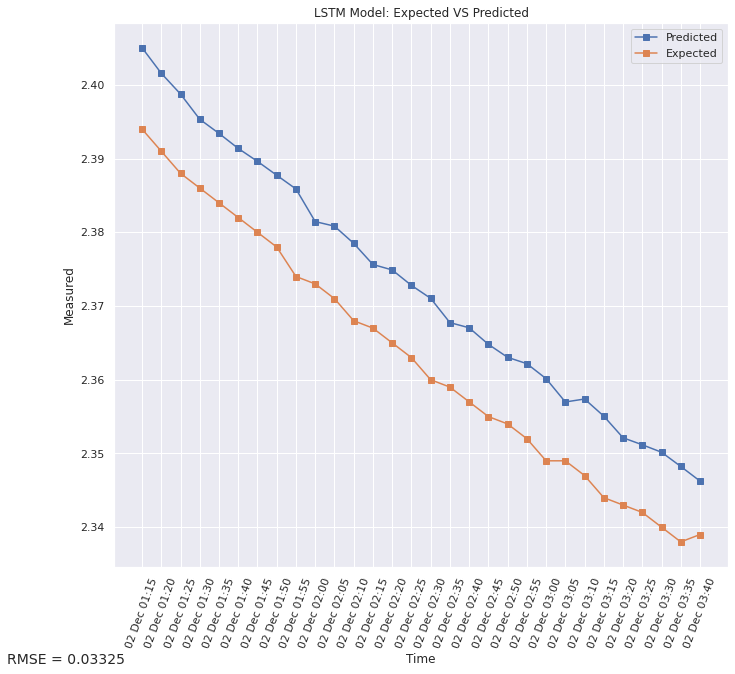

In [23]:
# Plot [start, end] interval
## 0 ~ 11824
start = 300
end = 330
plot_predicted_vs_expected(results["predicted"], results["expected"], results["overall_score"], data.index, start, end)

## Scatter Plot

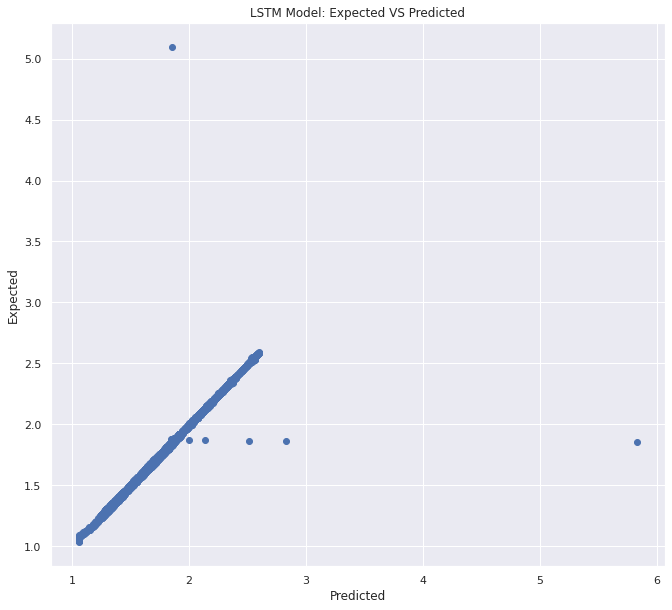

In [24]:
start = 0
end = -1
scatter_plot(results["predicted"], results["expected"], start, end)

## Main - Classification

### 1) Spikes | S


Limit: 0.04363

Spike (S):

  General:
    - TP: 6629
    - TN: 19885
    - FP: 4
    - FN: 0
    - Hits: 26514
    - Misses: 4
    - Total (hits + misses): 26518

  Metrics:
    - Accuracy: 99.98%
    - Precision: 99.94%
    - Recall: 100.0%
    - F1-Score: 99.97%


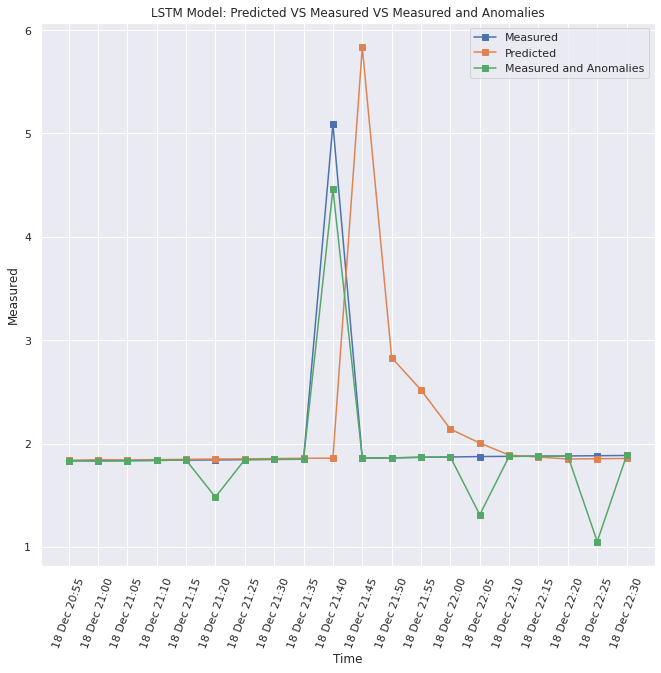

In [25]:
# Read "Spike" data
anomaly_type = "s"
s_data = read_anomaly_data("./csvs/test_set", anomaly_type)

# Create and init the classifier
clf = Classifier()
clf.init()
clf.get_mav_data(results["predicted"], s_data)
clf.get_expected_classes(results["expected"])

# Calculates the MAPE
mape = get_MAPE(results["predicted"], results["expected"])

# Defines the limit
limit = mape * FACTOR
print("\nLimit: {:.4}\n".format(limit))

# Make the classification and show the metrics
clf.get_classification(results["predicted"], limit)
clf.get_metrics(anomaly_type)

# Shows in which anomaly the classifier missed
clf.show_the_wrongs_predictions(results["predicted"], results["expected"], data.index, 0, anomaly_type)

### 2) Stationary Values | SV


Limit: 0.02182

Stationary Value (SV):

  General:
    - TP: 165
    - TN: 20615
    - FP: 5
    - FN: 5733
    - Hits: 20780
    - Misses: 5738
    - Total (hits + misses): 26518

  Metrics:
    - Accuracy: 78.36%
    - Precision: 97.06%
    - Recall: 2.798%
    - F1-Score: 5.438%


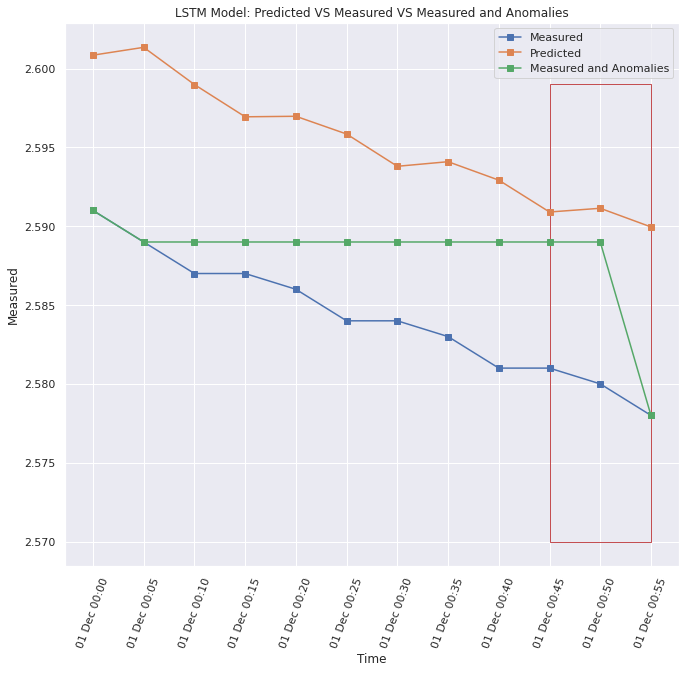

In [26]:
# Read "Stationary Values" data
anomaly_type = "sv"
sv_data = read_anomaly_data("./csvs/test_set", anomaly_type)

# Create and init the classifier
clf = Classifier()
clf.init()
clf.get_mav_data(results["predicted"], sv_data)
clf.get_expected_classes(results["expected"])

# Calculates the MAPE
mape = get_MAPE(results["predicted"], results["expected"])

# Defines the limit
limit = mape * (FACTOR / 2)
print("\nLimit: {:.4}\n".format(limit))

# Make the classification and show the metrics
clf.get_classification(results["predicted"], limit)
clf.get_metrics(anomaly_type)

# Shows in which anomaly the classifier missed
clf.show_the_wrongs_predictions(results["predicted"], results["expected"], data.index, 0, anomaly_type)

### 3) Sensor Displacement | SD


Limit: 0.04363

Sensor Displacement (SD):

  General:
    - TP: 6633
    - TN: 19882
    - FP: 2
    - FN: 1
    - Hits: 26515
    - Misses: 3
    - Total (hits + misses): 26518

  Metrics:
    - Accuracy: 99.99%
    - Precision: 99.97%
    - Recall: 99.98%
    - F1-Score: 99.98%


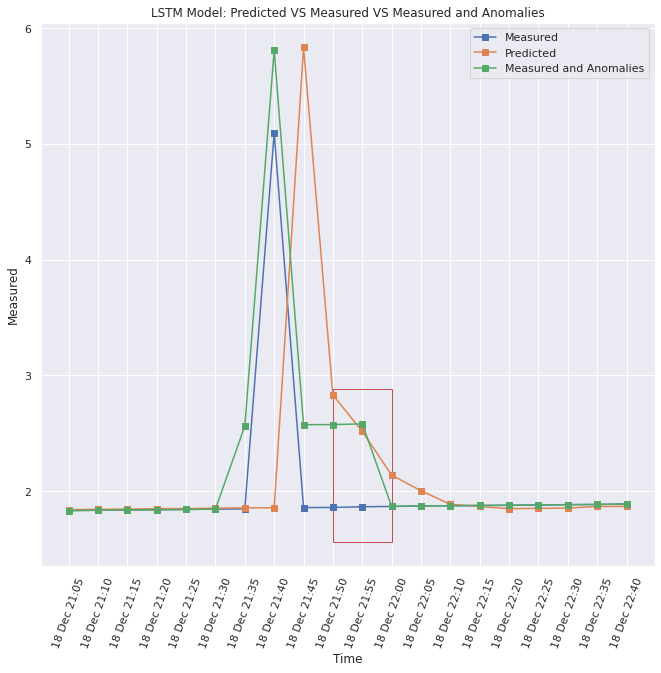

In [27]:
# Read "Sensor Displacement" data
anomaly_type = "sd"
sd_data = read_anomaly_data("./csvs/test_set", anomaly_type)

# Create and init the classifier
clf = Classifier()
clf.init()
clf.get_mav_data(results["predicted"], sd_data)
clf.get_expected_classes(results["expected"])

# Calculates the MAPE
mape = get_MAPE(results["predicted"], results["expected"])

# Defines the limit
limit = mape * FACTOR
print("\nLimit: {:.4}\n".format(limit))

# Make the classification and show the metrics
clf.get_classification(results["predicted"], limit)
clf.get_metrics(anomaly_type)

# Shows in which anomaly the classifier missed
clf.show_the_wrongs_predictions(results["predicted"], results["expected"], data.index, 0, anomaly_type)

## 4) S + SV


Limit: 0.04363

Spike (S) and Stationary Value (SV):

  General:
    - TP: 987
    - TN: 20570
    - FP: 6
    - FN: 4955
    - Hits: 21557
    - Misses: 4961
    - Total (hits + misses): 26518

  Metrics:
    - Accuracy: 81.29%
    - Precision: 99.4%
    - Recall: 16.61%
    - F1-Score: 28.46%


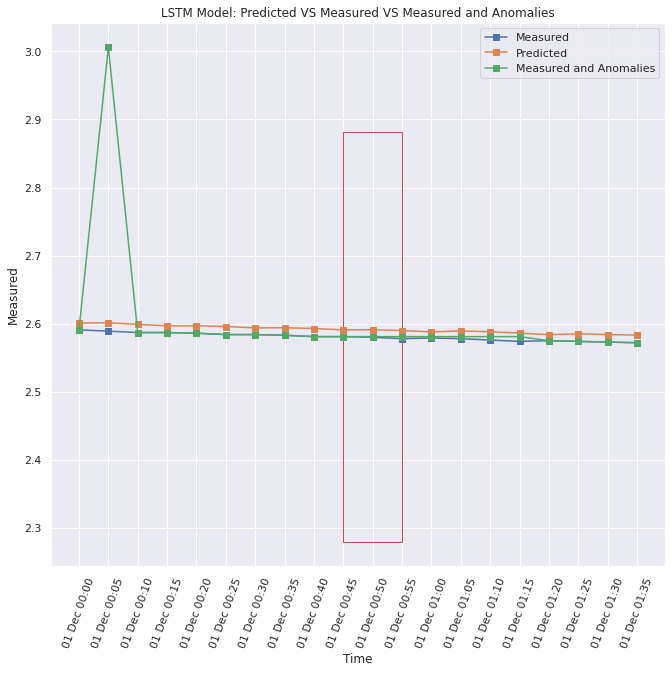

In [28]:
# Read "Spike + Stationary Values" data
anomaly_type = "s+sv"
s_sv_data = read_anomaly_data("./csvs/test_set", anomaly_type)

# Create and init the classifier
clf = Classifier()
clf.init()
clf.get_mav_data(results["predicted"], s_sv_data)
clf.get_expected_classes(results["expected"])

# Calculates the MAPE
mape = get_MAPE(results["predicted"], results["expected"])

# Defines the limit
limit = mape * FACTOR
print("\nLimit: {:.4}\n".format(limit))

# Make the classification and show the metrics
clf.get_classification(results["predicted"], limit)
clf.get_metrics(anomaly_type)

# Shows in which anomaly the classifier missed
clf.show_the_wrongs_predictions(results["predicted"], results["expected"], data.index, 0, anomaly_type)

## 5) S + SD


Limit: 0.04363

Spike (S) and Sensor Displacement (SD):

  General:
    - TP: 6636
    - TN: 19876
    - FP: 6
    - FN: 0
    - Hits: 26512
    - Misses: 6
    - Total (hits + misses): 26518

  Metrics:
    - Accuracy: 99.98%
    - Precision: 99.91%
    - Recall: 100.0%
    - F1-Score: 99.95%


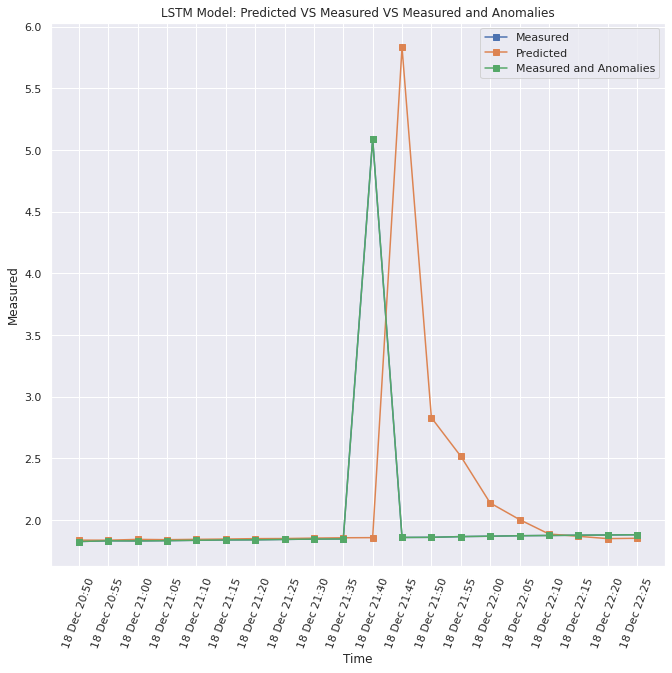

In [29]:
# Read "Spike + Sensor Displacement" data
anomaly_type = "s+sd"
s_sd_data = read_anomaly_data("./csvs/test_set", anomaly_type)

# Create and init the classifier
clf = Classifier()
clf.init()
clf.get_mav_data(results["predicted"], s_sd_data)
clf.get_expected_classes(results["expected"])

# Calculates the MAPE
mape = get_MAPE(results["predicted"], results["expected"])

# Defines the limit
limit = mape * FACTOR
print("\nLimit: {:.4}\n".format(limit))

# Make the classification and show the metrics
clf.get_classification(results["predicted"], limit)
clf.get_metrics(anomaly_type)

# Shows in which anomaly the classifier missed
clf.show_the_wrongs_predictions(results["predicted"], results["expected"], data.index, 0, anomaly_type)

## 6) SV + SD


Limit: 0.04363

Stationary Value (SV) and Sensor Displacement (SD):

  General:
    - TP: 3366
    - TN: 20287
    - FP: 4
    - FN: 2861
    - Hits: 23653
    - Misses: 2865
    - Total (hits + misses): 26518

  Metrics:
    - Accuracy: 89.2%
    - Precision: 99.88%
    - Recall: 54.05%
    - F1-Score: 70.15%


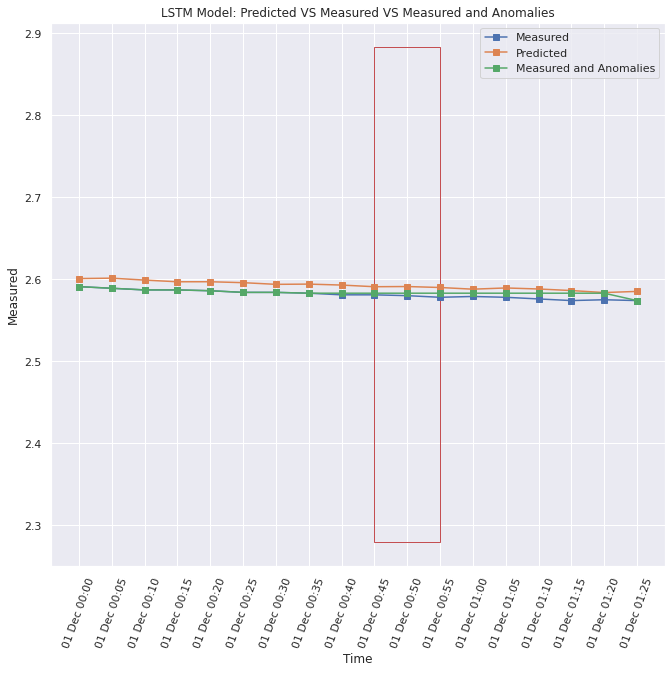

In [30]:
# Read "Stationary Values + Sensor Displacement" data
anomaly_type = "sv+sd"
sv_sd_data = read_anomaly_data("./csvs/test_set", anomaly_type)

# Create and init the classifier
clf = Classifier()
clf.init()
clf.get_mav_data(results["predicted"], sv_sd_data)
clf.get_expected_classes(results["expected"])

# Calculates the MAPE
mape = np.mean(np.abs((results["expected"] - results["predicted"]) / results["expected"]))

# Calculates the MAPE
mape = get_MAPE(results["predicted"], results["expected"])

# Defines the limit
limit = mape * FACTOR
print("\nLimit: {:.4}\n".format(limit))

# Make the classification and show the metrics
clf.get_classification(results["predicted"], limit)
clf.get_metrics(anomaly_type)

# Shows in which anomaly the classifier missed
clf.show_the_wrongs_predictions(results["predicted"], results["expected"], data.index, 0, anomaly_type)

## 7) S + SV + SD


Limit: 0.04363

Spike (S) and Stationary Value (SV) and Sensor Displacement (SD):

  General:
    - TP: 3603
    - TN: 20235
    - FP: 0
    - FN: 2680
    - Hits: 23838
    - Misses: 2680
    - Total (hits + misses): 26518

  Metrics:
    - Accuracy: 89.89%
    - Precision: 100.0%
    - Recall: 57.35%
    - F1-Score: 72.89%


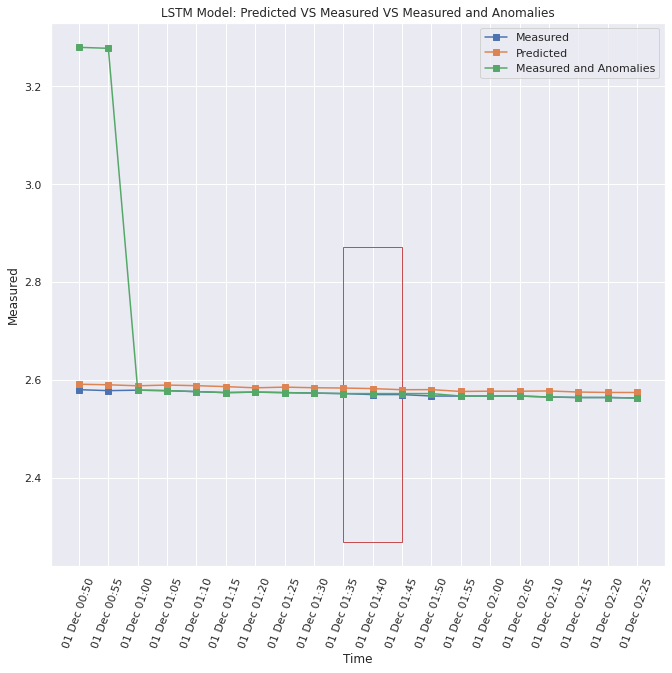

In [31]:
# Read "Spike + Stationary Values + Sensor Displacement" data
anomaly_type = "s+sv+sd"
s_sv_sd_data = read_anomaly_data("./csvs/test_set", anomaly_type)

# Create and init the classifier
clf = Classifier()
clf.init()
clf.get_mav_data(results["predicted"], s_sv_sd_data)
clf.get_expected_classes(results["expected"])

# Calculates the MAPE
mape = np.mean(np.abs((results["expected"] - results["predicted"]) / results["expected"]))

# Calculates the MAPE
mape = get_MAPE(results["predicted"], results["expected"])

# Defines the limit
limit = mape * FACTOR
print("\nLimit: {:.4}\n".format(limit))

# Make the classification and show the metrics
clf.get_classification(results["predicted"], limit)
clf.get_metrics(anomaly_type)

# Shows in which anomaly the classifier missed
clf.show_the_wrongs_predictions(results["predicted"], results["expected"], data.index, 0, anomaly_type)